# Plastic Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/surfriderfoundationeurope/IA_Pau/blob/master/Hackaton_Surfrider_Getting_Started.ipynb)


The goal is to build a plastic classifier, as the core detector / tracker is already built (but only works for generic plastic).

If you want fast training, make sure you have a good GPU: check using the command `!nvidia-smi`

Please install the required packages:   
`pip install -r requirements.txt`

### Getting the data

To get the images of [taco](http://tacodataset.org/) project, you download the dataset from [here](https://www.kaggle.com/kneroma/tacotrashdataset).        
Then put the `data` content folder in the `data/images/` folder of this repository, to have this structure:
- `data/images/`
    - `bach_1/`
    - `bach_2/`
    - `bach_3/`
    - ...
    - `annotations.json`
    - `meta_df.csv`

In [23]:
import json
import random
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.insert(0,'../')

## Analyse the dataset

the next following cells enable you to get a bit of information about the dataset

In [26]:
# split annotation file into train and test

annotationFile = '../../data/images/meta_df.csv'
annotationFileTrain = '../../data/images/meta_df_train.csv'
annotationFileTest = '../../data/images/meta_df_test.csv'

train_ratio=0.8
with open(annotationFile, 'r') as f:
    lines = f.readlines()
    header = lines[0]
    lines = lines[1:]
    random.shuffle(lines)
    train_size = int(len(lines) * train_ratio)
    train_lines = lines[:train_size]
    test_lines = lines[train_size:]
    with open(annotationFileTrain, 'w') as f_train:
        f_train.write(header)
        f_train.writelines(train_lines)
    with open(annotationFileTest, 'w') as f_test:
        f_test.write(header)
        f_test.writelines(test_lines)

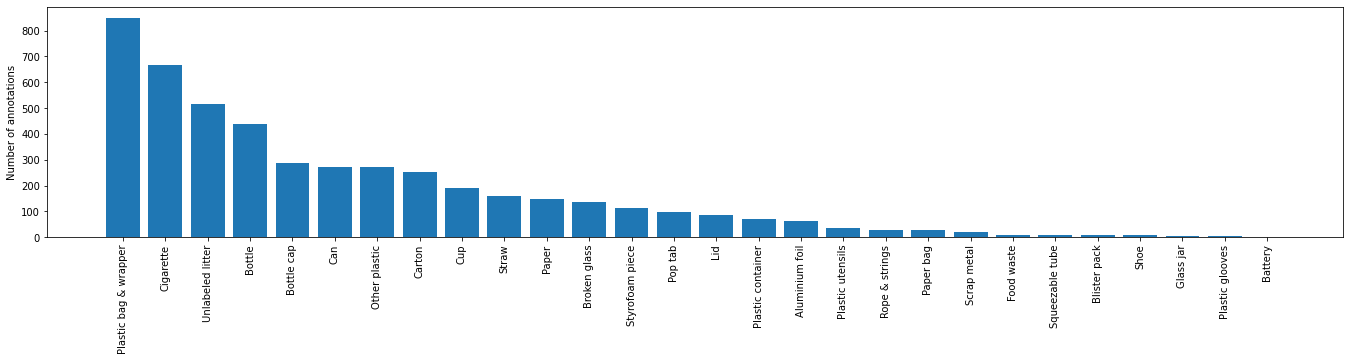

In [41]:
dataset = pd.read_csv(annotationFile)
coco_categories = dataset['supercategory']

# get coco categories names and how many images are in each category
cat_names = list(set(coco_categories))
nb_images = {}
for cat in cat_names:
    nb_images.update({cat: len(coco_categories[coco_categories == cat])})
# sort by number of images
cat_names = sorted(nb_images, key=nb_images.get, reverse=True)
nb_images = sorted(nb_images.values(), reverse=True)

plt.bar(x = cat_names, height = nb_images)
plt.xticks(range(len(cat_names)), cat_names, rotation='vertical')
plt.ylabel('Number of annotations')
plt.tight_layout()
plt.autoscale(True)
# set full width
plt.subplots_adjust(left=0.0, right=3.0, top=0.9, bottom=0.1)
# plt.savefig('dataset_analysis')
plt.show()

In [ ]:
import os
from detection.coco_utils import CocoDetectionWithExif, ConvertCocoPolysToBboxes

def get_dataset(root, image_set):
    PATHS = {
        "train": ("images", os.path.join("annotations", "instances_train.json")),
        "val": ("images", os.path.join("annotations", "instances_val.json")),
    }

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    dataset = CocoDetectionWithExif(img_folder, ann_file, transforms=ConvertCocoPolysToBboxes())

    return dataset

In [ ]:
from detection.coco_utils import get_surfrider
from detection import transforms

base_size = 540
crop_size = (544, 960)
downsampling_factor = 4
num_classes = 10
path = '/content/surfnet/data/images/'

# Building a train & test dataset
train_dataset = get_dataset(path, "train")
val_dataset = get_dataset(path, "val")

Let us display a full size picture, and corresponding bounding box

In [ ]:
import matplotlib.pyplot as plt
x, y = next(iter(train_dataset))
print(x.shape, y)
plt.imshow(x)